# Usecase showcasing Regional Benchmarking service of Anomaly Identification

The openEO-based Regional Benchmarking service allows users to monitor crop growth on a specific field and compare it with similar fields in the region. This comparison helps determine if the field is performing better or worse than other fields, providing valuable insights for agricultural management.

In this example, we compared several fields within our area of interest with a similar crop type. The area of interest was derived using WFS from the DLV service, filtered by the crop type 'Zomergerst'. However, users can use their polygons or parcels for comparison, provided they are of a similar crop type.

In [1]:
# importing necessary packages
import openeo
import requests
import json
import geopandas as gpd
from shapely.geometry import box
import folium

In [5]:
# Acquire more information about the service
service = "Anomaly_Detection"
namespace = "vito"

eoconn = openeo.connect("https://openeo.vito.be").authenticate_oidc()
eoconn.describe_process(service, namespace=namespace)

Authenticated using refresh token.


{'description': '# Anomaly Detection\n\nWith our Regional Benchmarking service in anomaly identification, you can check the crop growth on your field and compare it with similar fields in the region. It gives you an idea of whether your field is performing better or worse than other fields.\n\nThe service calculates the CropSAR fAPAR curve for each field and the regional average fAPAR curve calculated from comparable fields in the region during a given time period. \n',
 'id': 'Anomaly_Detection',
 'parameters': [{'description': 'Left-closed temporal interval, i.e. an array with exactly two elements:\n\n1. The first element is the start of the temporal interval. The specified instance in time is **included** in the interval.\n2. The second element is the end of the temporal interval. The specified instance in time is **excluded** from the interval.\n\nThe specified temporal strings follow [RFC 3339](https://www.rfc-editor.org/rfc/rfc3339.html). Also supports open intervals by setting one of the boundaries to `null`, but never both.',
   'name': 'date',
   'schema': {'examples': [['2015-01-01T00:00:00Z', '2016-01-01T00:00:00Z'],
     ['2015-01-01', '2016-01-01']],
    'items': {'anyOf': [{'format': 'date-time',
       'subtype': 'date-time',
       'type': 'string'},
      {'format': 'date', 'subtype': 'date', 'type': 'string'},
      {'maxLength': 4,
       'minLength': 4,
       'pattern': '^\\d{4}$',
       'subtype': 'year',
       'type': 'string'},
      {'type': 'null'}]},
    'maxItems': 2,
    'minItems': 2,
    'subtype': 'temporal-interval',
    'type': 'array'}},
  {'description': 'Loaded featurecollection object of the field geometries',
   'name': 'polygon',
   'schema': {'subtype': 'geojson', 'type': 'object'}},
  {'default': 'FAPAR',
   'description': 'BIOPAR type [FAPAR,FCOVER] used to calculate the CropSAR curve on. As default the FAPAR is used',
   'name': 'biopar_type',
   'optional': True,
   'schema': {'type': 'string'}}]}

As mentioned earlier, though, in this example, we used parcels from a WFS; these parameters are specific to them. User can use their polygons/parcels based on their requirements. 

In [8]:
# Specific parameters
croptype = "Zomergerst"

# Bounding Box
west = 5.17
east = 5.3
south = 51.1
north = 52.246

In [9]:
# reading the json file (user can use this function if they have their features stored as json file)


def read_json_str(json_txt: str) -> dict:
    field = json.loads(json_txt)
    return field

## Parse the data

Here, we parsed WFS data from [https://lv.vlaanderen.be/en](https://lv.vlaanderen.be/en) to obtain parcels with their respective crop types.

In [10]:
# requesting data over a region for a specific crop type

url = f"https://geo.api.vlaanderen.be/Landbgebrperc/wfs?service=WFS&request=getfeature&cql_filter=LBLHFDTLT='{croptype}'&outputformat=json&typename=Lbgebrperc&SRSName=urn:x-ogc:def:crs:EPSG:4326"
req = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

wfs_request_url = (
    requests.Request("GET", url, headers={"User-Agent": "Mozilla/5.0"}).prepare().url
)
data = req.json()

Before proceeding, we want to ensure that the filtered data lies within the area of interest. The following cell includes a method to display the parsed data as a dataframe and on a map.

In [11]:
dataframe = gpd.GeoDataFrame.from_features(data["features"], crs="EPSG:4326")
area = dataframe.to_crs(epsg=3857).area
dataframe = dataframe[area > 200]

# filter data within the bounding box
bbox = box(west, south, east, north)
dataframe = dataframe[dataframe.within(bbox)]

dataframe = dataframe.head()
# converting dataframe to geojson string
geojson_str = dataframe.to_json()

dataframe

,geometry,UIDN,OIDN,ALVID,HFDTLT,LBLHFDTLT,GEWASGROEP,PM,LBLPM
10,"POLYGON ((5.29093 51.20048, 5.29086 51.20056, ...",4367507,1523096,1860308032,322,Zomergerst,"Granen, zaden en peulvruchten",,
44,"POLYGON ((5.18902 51.18327, 5.18902 51.18333, ...",4701063,1578592,1968471924,322,Zomergerst,"Granen, zaden en peulvruchten",,
99,"POLYGON ((5.17625 51.16141, 5.17624 51.16141, ...",4736113,1401727,1748157137,322,Zomergerst,"Granen, zaden en peulvruchten",,
140,"POLYGON ((5.29437 51.18630, 5.29466 51.18570, ...",4720017,405396,423080654,322,Zomergerst,"Granen, zaden en peulvruchten",,
145,"POLYGON ((5.24719 51.10475, 5.24698 51.10514, ...",4721711,1643282,2077021994,322,Zomergerst,"Granen, zaden en peulvruchten",,


In [13]:
# plot the polygons
map = folium.Map(tiles="OpenStreetMap", zoom_start=12, location=[51.243, 5.18])
points = folium.features.GeoJson(dataframe.to_crs("EPSG:4326").to_json())
map.add_child(points)
map.fit_bounds(map.get_bounds(), padding=(30, 30))
map

## Apply Anomaly Detection service


In [14]:
# parameters mandatory for this openeo-based service
aoi = read_json_str(geojson_str)
date = ["2020-03-06", "2020-06-30"]

# accessing the openeo service
anomaly = eoconn.datacube_from_process(
    service, namespace=namespace, date=date, polygon=aoi
)

In [15]:
# synchronous download or batch process
anomaly.download("RegionalBenchmarking_AD.json")

The service calculates the CropSAR fAPAR curve for each field. It compares it with the regional average fAPAR curve, derived from comparable fields in the region during a given time period.

## Visualize and compare the final result

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

data_json = json.load(open("RegionalBenchmarking_AD.json", "r"))

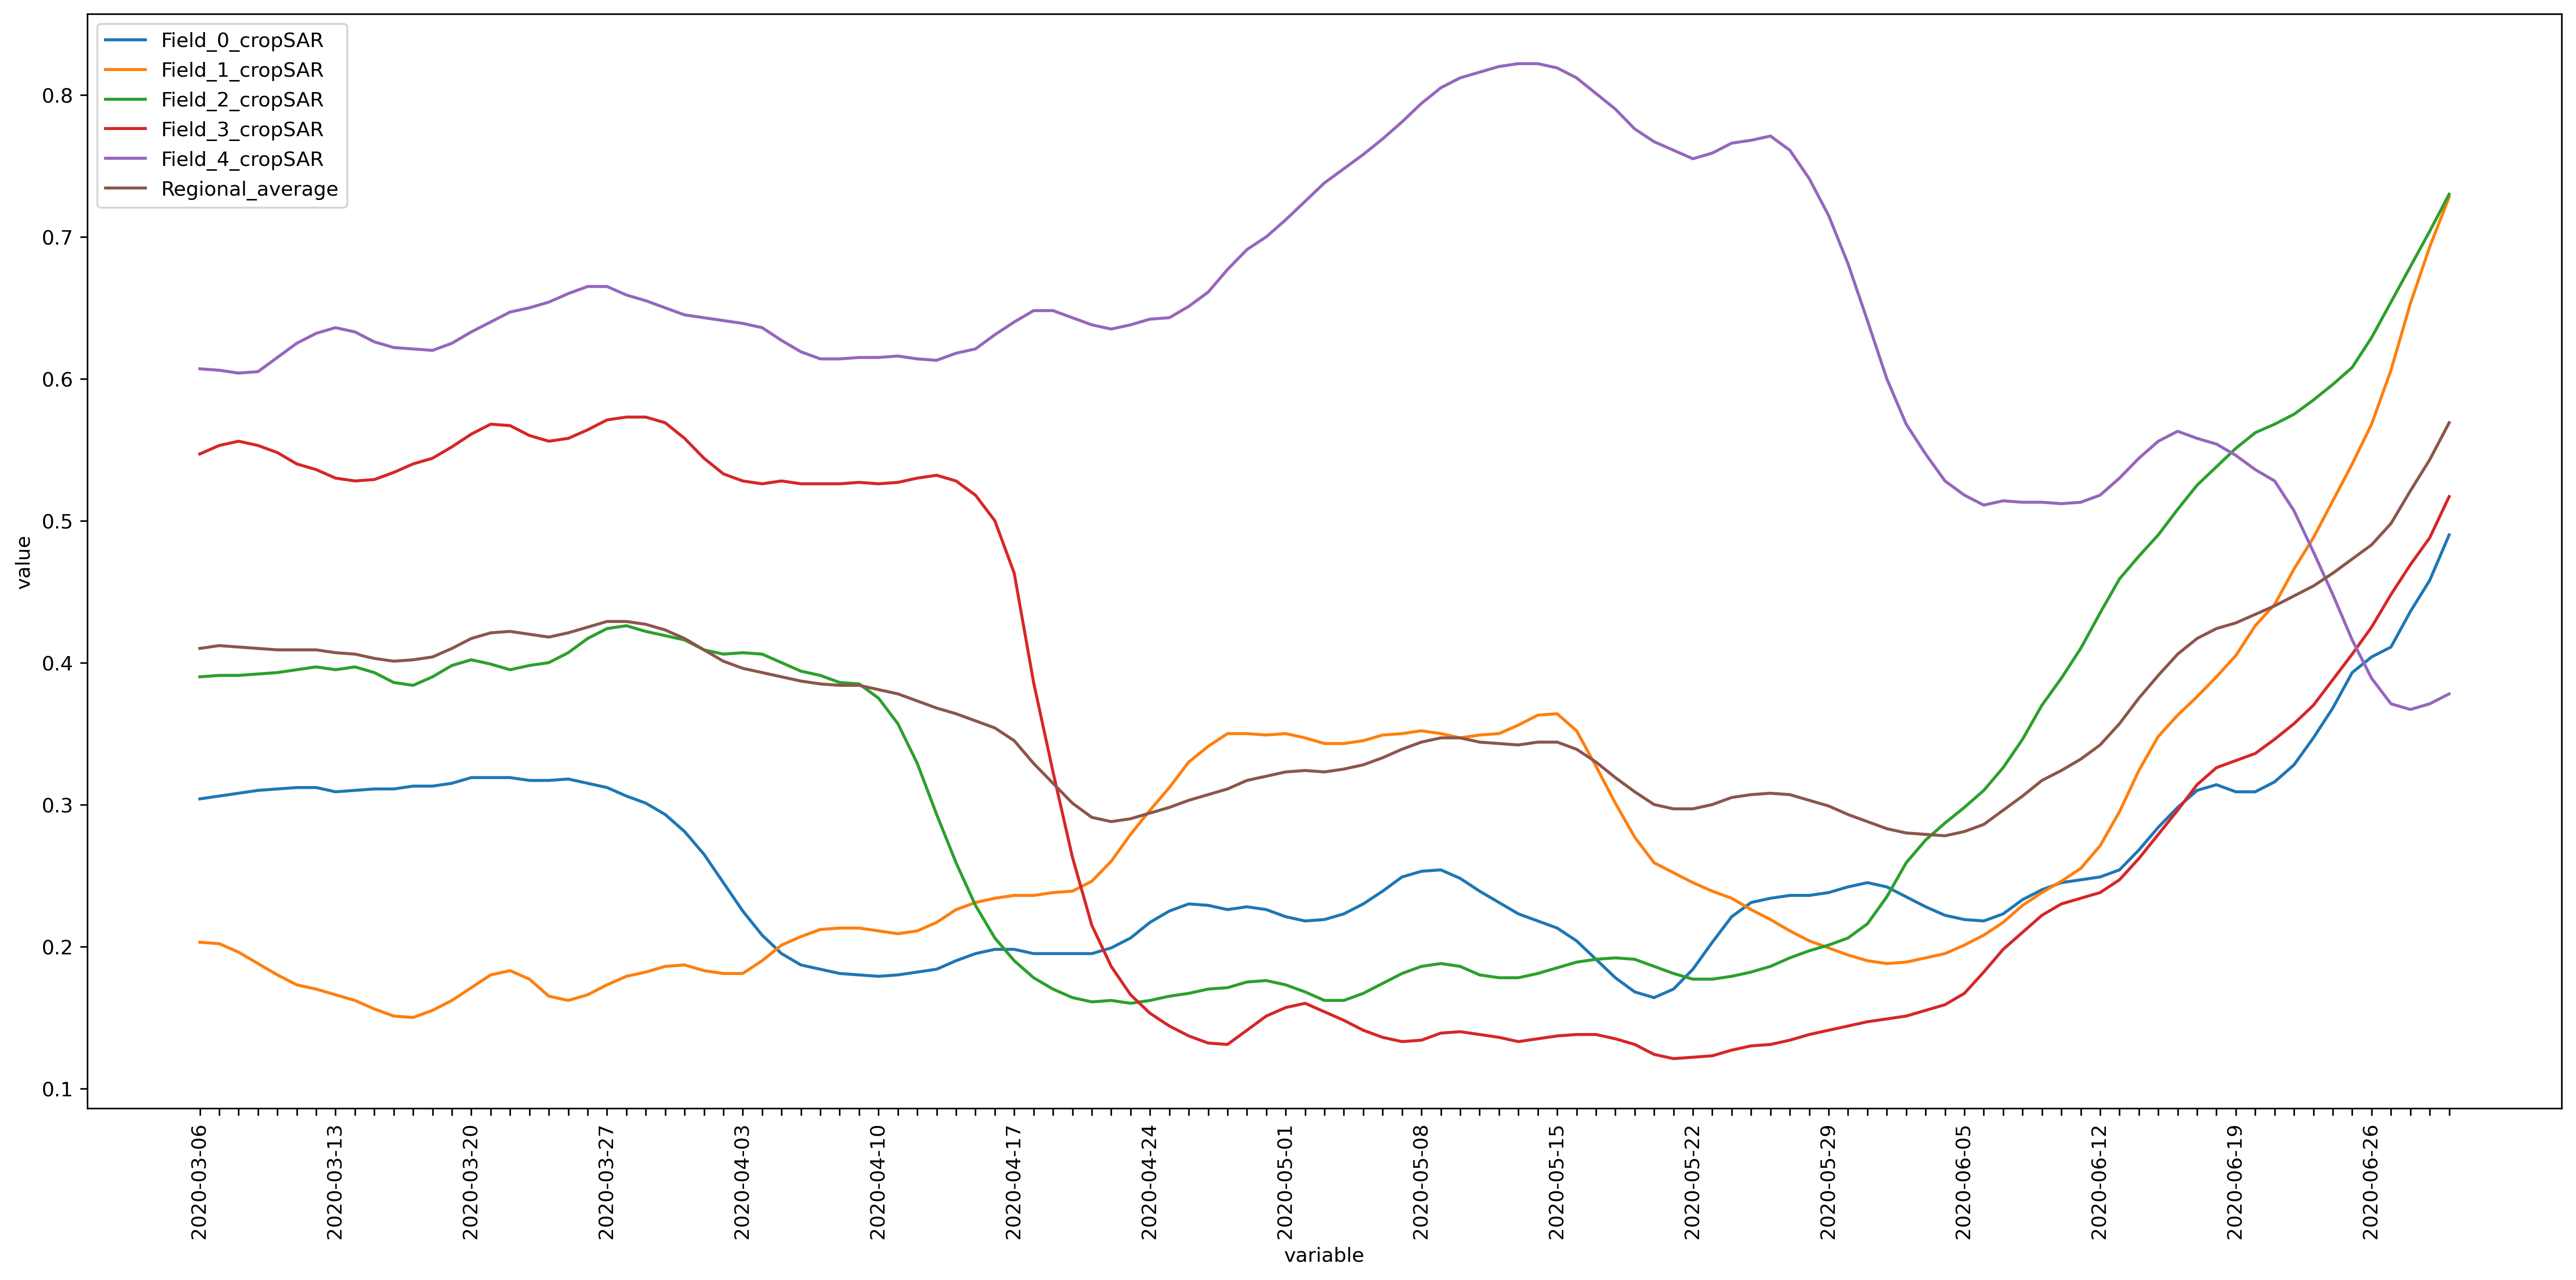

In [17]:
figure(figsize=(18, 9), dpi=300)
for i in data_json:
    x_Axis = [key for key, value in data_json[i].items()]
    y_Axis = [value for key, value in data_json[i].items()]
    plt.plot(x_Axis, y_Axis, label=i)

ax = plt.gca()
n = 7  # Keeps every 7th label
[l.set_visible(False) for (i, l) in enumerate(ax.get_xticklabels()) if i % n != 0]
plt.xlabel("variable")
plt.xticks(rotation=90)
plt.ylabel("value")
plt.tight_layout()
plt.legend()
plt.show()

Through the visualized curves, you can study the crop type behaviour of the field in comparison with the regional average.